# R Script CART Method
model and generation
code teilweise von https://medium.com/data-and-beyond/hyperparameter-tuning-and-pruning-more-about-k-means-clustering-in-r-with-rpart-9a405685a09b

Adult dataset:
Age, Final Weight, Education Number, Capital Gain, Capital Loss and Hours Per Week are integer columns.
There are no Float Datatypes in the dataset.
Workclass, Education, Marital Status, Occupation, Relationship, Race, Sex, Native Country and Income are of object datatypes.
The adult dataset is tranformed into numeric values (with mappings) and preprocessed (to not contain any missing values) in a python notebook 

?confusionMatrix
?rpart
--> wichtige benutzte Funktionen

In [9]:
list_of_packages <- c ("synthpop", "insight", "party", "rpart", "rpart.plot", "randomForest", "pROC", "caret", "pracma")

lapply(list_of_packages, FUN= function(X){
  do.call("require", list(X))
})

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

## Data
The datasets are CPS and Adult

In [10]:
directory <- "/Users/emmafoessing/Documents/Master/MA/Code/Master-Thesis"

In [11]:
load(paste0(directory,"/cpspop.RData"))
adult <- read.csv(paste0(directory, "/adult_preprocessed.csv"))

In [12]:
adult$workclass <- as.factor(adult$workclass)
adult$education <- as.factor(adult$education)
adult$marital_status <- as.factor(adult$marital_status)
adult$relationship <- as.factor(adult$relationship)
adult$race <- as.factor(adult$race)
adult$sex <- as.factor(adult$sex)
adult$native_country <- as.factor(adult$native_country)
adult$income <- as.factor(adult$income)

## Prerequisites

In [13]:
# Seed
set.seed(1234)
my_seed = 1234

### Functions

In [14]:
## Comparison fct for original vs. synthetic data

compare_syn_orig <- function(origdata = cpspop, syndata){
 
  print(compare(syndata, origdata))
  print_color('compare(syndata, origdata) done', 'green')
 
  model_origdata <- lm(log(income) ~ age + I(age^2) + educ + marital + race + sex, data = origdata)
  summary(model_origdata)
  print_color('model_origdata done', 'green')
 
  if(class(syndata) == "synds"){
    model_syn <- lm.synds(log(income) ~ age + I(age^2) + educ + marital + race + sex, data = syndata)
  } else {
    model_syn <- lm(log(income) ~ age + I(age^2) + educ + marital + race + sex, data = syndata)
  }
 
  summary(model_syn)
  print_color('model_syn done', 'green')
 
  print(compare.fit.synds(model_syn, cpspop, plot = "coef")) # here not possible to use a function specified argument for the original data
  print_color('compare regression done', 'green')
}

In [15]:
## tree fct with control component

build_tree <- function(data, trainsplit = 0.8){
    train_index <- sample(1:nrow(data), nrow(data)*trainsplit)
    # train dataset formation
    train_set <- data[train_index, ]
    # test dataset formation
    test_set <- data[-train_index, ]

    tree <- rpart(income ~ ., data = train_set)

    # Predict on the test set
    predictions <- predict(tree, test_set)#, type = "prob")


    # for factored variables this will give probabilities, so there is a need to create the actual predictions
    if (is.factor(data$income)){
        # Initialize predictions as just the probability predictions
        predictions_prob <- predictions
        predictions <- list(probabilities = predictions_prob)
        preds <- apply(predictions_prob, 1, function(row) {
            # Get the index of the max value in the row
            max_index <- which.max(row)
            # Return the column name using the index
            return(colnames(predictions_prob)[max_index])
        })
        # Add actual predictions to the predictions list
        predictions$classes <- as.factor(preds)
    }

    # plot the tree
    rpart.plot(tree)

    # Results
    results <- list(train_set, test_set, tree, predictions)
    names(results) <- c("train_set", "test_set", "tree", "predictions")
    return(results)
}

In [16]:
## Calculate evaluation metrics for continuous target variable income

evaluation_metrics <- function(predictions_advanced, test_set){
  MAE <- mean(abs(predictions_advanced - test_set$income))
  MSE <- mean((predictions_advanced - test_set$income)^2)
  RMSE <- sqrt(MSE)

  SS_res <- sum((test_set$income - predictions_advanced)^2)
  SS_tot <- sum((test_set$income - mean(test_set$income))^2)
  R_squared <- 1 - (SS_res / SS_tot)

  MAPE <- mean(abs((test_set$income - predictions_advanced) / test_set$income)) * 100

  # Create a data frame for the metrics
  evaluation_table <- data.frame(
    Metric = c("Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)",
              "R-squared (R²)", "Mean Absolute Percentage Error (MAPE)"),
    Value = c(MAE, MSE, RMSE, R_squared, MAPE)
  )

  # Format the values in the Value column to display without scientific notation
  evaluation_table$Value <- format(evaluation_table$Value, scientific = FALSE)

  # Print the evaluation table
  print(evaluation_table)
}

In [17]:
## Calculate evaluation metrics for factored targets

evaluation_metrics_factor <- function(predictions_orig, test_set_orig, predictions_syn, test_set_syn){
    # confusion matrix for the prediction on original data
    cm_orig <- confusionMatrix(predictions_orig, test_set_orig$income,
                mode = "everything")
    # confusion matrix for the prediction on synthetic data         
    cm_syn <- confusionMatrix(predictions_syn, test_set_syn$income,
                mode = "everything")

    # saving evaluation metrics
    accuracy_orig <- cm_orig$overall['Accuracy']
    f1_orig       <- cm_orig$byClass['F1']
    sens_orig     <- cm_orig$byClass['Sensitivity']
    spec_orig     <- cm_orig$byClass['Specificity']
    accuracy_syn  <- cm_syn$overall['Accuracy']
    f1_syn        <- cm_syn$byClass['F1']
    sens_syn      <- cm_syn$byClass['Sensitivity']
    spec_syn      <- cm_syn$byClass['Specificity']

    # Saving the differences
    accuracy_diff <- accuracy_syn - accuracy_orig
    f1_diff <- f1_syn - f1_orig
    sens_diff <- sens_syn - sens_orig
    spec_diff <- spec_syn - spec_orig

    # Create the dataframe
    metrics_df <- data.frame(
    Metric = c("Accuracy", "F1", "Sensitivity", "Specificity"),
    Original = c(accuracy_orig, f1_orig, sens_orig, spec_orig),
    Synthetic = c(accuracy_syn, f1_syn, sens_syn, spec_syn),
    Difference = c(accuracy_diff, f1_diff, sens_diff, spec_diff)
    )

    return(metrics_df)
}

## Generate data

### CPS

In [18]:
syndata_cart_cps <- syn(cpspop, seed = my_seed)
#compare_syn_orig(syndata = syndata_cart_cps)


Synthesis
-----------
 tax income csp age educ marital race sex ss


### Adult

In [19]:
syndata_cart_adult <- syn(adult, seed = my_seed, cart.cp = 0.01)
#compare_syn_orig(syndata = syndata_cart_adult) --> funktioniert nicht mit den Variablen


Synthesis
-----------
 age workclass fnlwgt education marital_status occupation relationship race sex capital_gain
 capital_loss hours_per_week native_country income


# Prediction Regression and Classification

## CPS

#### Original data

In [178]:
?predict.rpart

predict.rpart              package:rpart               R Documentation

_P_r_e_d_i_c_t_i_o_n_s _f_r_o_m _a _F_i_t_t_e_d _R_p_a_r_t _O_b_j_e_c_t

_D_e_s_c_r_i_p_t_i_o_n:

     Returns a vector of predicted responses from a fitted 'rpart'
     object.

_U_s_a_g_e:

     ## S3 method for class 'rpart'
     predict(object, newdata,
            type = c("vector", "prob", "class", "matrix"),
            na.action = na.pass, ...)
     
_A_r_g_u_m_e_n_t_s:

  object: fitted model object of class '"rpart"'.  This is assumed to
          be the result of some function that produces an object with
          the same named components as that returned by the 'rpart'
          function.

 newdata: data frame containing the values at which predictions are
          required.  The predictors referred to in the right side of
          'formula(object)' must be present by name in 'newdata'.  If
          missing, the fitted values are returned.



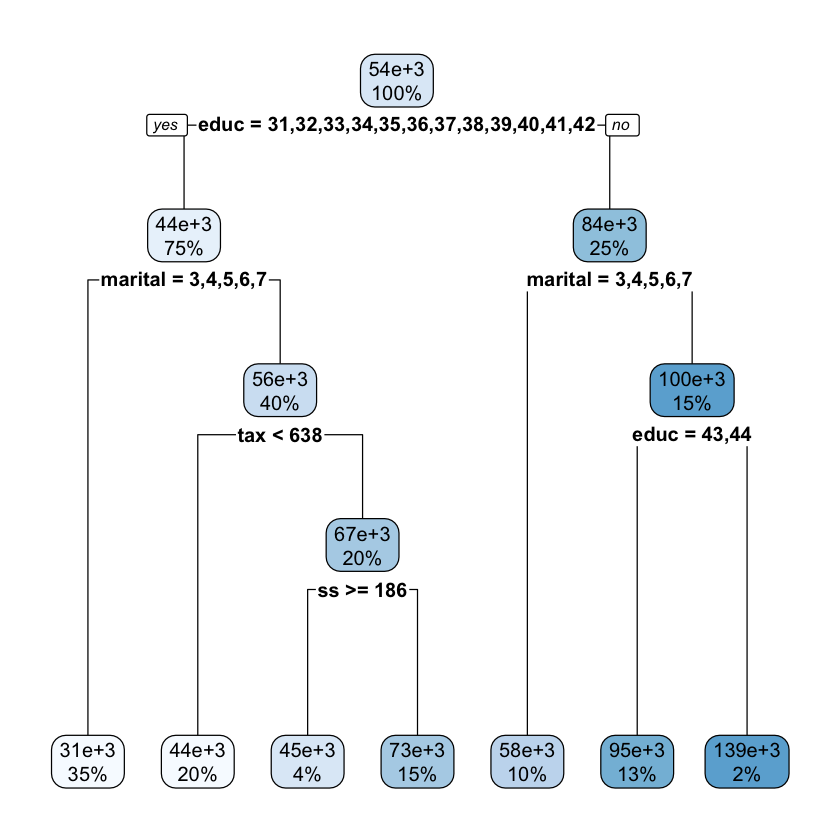

In [181]:
cps_tree_orig <- build_tree(cpspop)

In [185]:
printcp(cps_tree_orig$tree)


Regression tree:
rpart(formula = income ~ ., data = train_set, control = control)

Variables actually used in tree construction:
[1] educ    marital ss      tax    

Root node error: 9.71e+13/39548 = 2455256087

n= 39548 

        CP nsplit rel error  xerror     xstd
1 0.121671      0   1.00000 1.00002 0.019287
2 0.044570      1   0.87833 0.87843 0.017331
3 0.044172      2   0.83376 0.83890 0.016819
4 0.020956      3   0.78959 0.78997 0.016314
5 0.013824      4   0.76863 0.76914 0.016081
6 0.010484      5   0.75481 0.75539 0.015611
7 0.010000      6   0.74432 0.74909 0.015621


#### Performance evaluation

In [156]:
eval_tree_cps_orig <- evaluation_metrics(cps_tree_orig$predictions, cps_tree_orig$test_set)

                                 Metric              Value
1             Mean Absolute Error (MAE)      28101.1231031
2              Mean Squared Error (MSE) 1940094493.1390493
3        Root Mean Squared Error (RMSE)      44046.5037561
4                 R-squared (R<U+00B2>)          0.2453859
5 Mean Absolute Percentage Error (MAPE)       4661.0533891


In [157]:
# natürlich funktioniert hier keine CM weil es stetige Werte sind und keine Klassen

#cm <- confusionMatrix(predictions_advanced, test_set$income)
#print("Tuned model")
#cm

#### Synthetic data

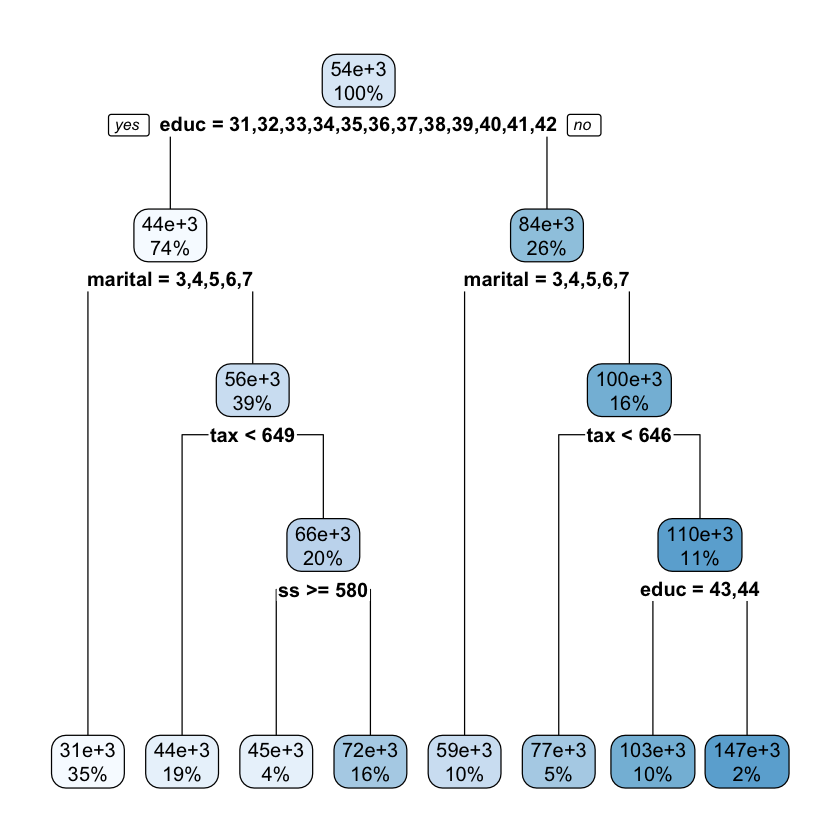

In [158]:
cps_tree_syn <- build_tree(syndata_cart_cps$syn)

In [159]:
eval_tree_cps_syn  <- evaluation_metrics(cps_tree_syn$predictions, cps_tree_syn$test_set)

                                 Metric              Value
1             Mean Absolute Error (MAE)      26918.1693315
2              Mean Squared Error (MSE) 1629081027.3900824
3        Root Mean Squared Error (RMSE)      40361.8759152
4                 R-squared (R<U+00B2>)          0.2658898
5 Mean Absolute Percentage Error (MAPE)       5666.5016004


#### Look at the differences

Hier könnte man überlegen, die jeweiligen Werte (Differenzen), die die Hypothese unterstützen grün zu markieren (Syndata schneidet besser ab als original) und andersrum rot <br>
Man könnte auch die Dataframe-calc. mit in die evaluation einbauen

für die Verschiedenen runs: 
Einen langen df mit nur den Differenzen gespeichert und dann eine finale Spalte mit den avg. Differences

In [160]:
# Convert Value columns to numeric
eval_tree_cps_orig$Value <- as.numeric(eval_tree_cps_orig$Value)
eval_tree_cps_syn$Value <- as.numeric(eval_tree_cps_syn$Value)

# Merge the two dataframes
dif_trees_cps <- merge(eval_tree_cps_orig, eval_tree_cps_syn, by = "Metric", suffixes = c("_orig", "_syn"))

# Calculate the numeric difference
dif_trees_cps$Difference <- dif_trees_cps$Value_syn - dif_trees_cps$Value_orig

print(dif_trees_cps)


                                 Metric   Value_orig    Value_syn    Difference
1             Mean Absolute Error (MAE) 2.810112e+04 2.691817e+04 -1.182954e+03
2 Mean Absolute Percentage Error (MAPE) 4.661053e+03 5.666502e+03  1.005448e+03
3              Mean Squared Error (MSE) 1.940094e+09 1.629081e+09 -3.110135e+08
4                 R-squared (R<U+00B2>) 2.453859e-01 2.658898e-01  2.050390e-02
5        Root Mean Squared Error (RMSE) 4.404650e+04 4.036188e+04 -3.684628e+03


Accuracy: The number of correct predictions made divided by the total number of predictions made. <br>
F1: CM based
--> not suitable for cps Data

## Adult

#### Original data

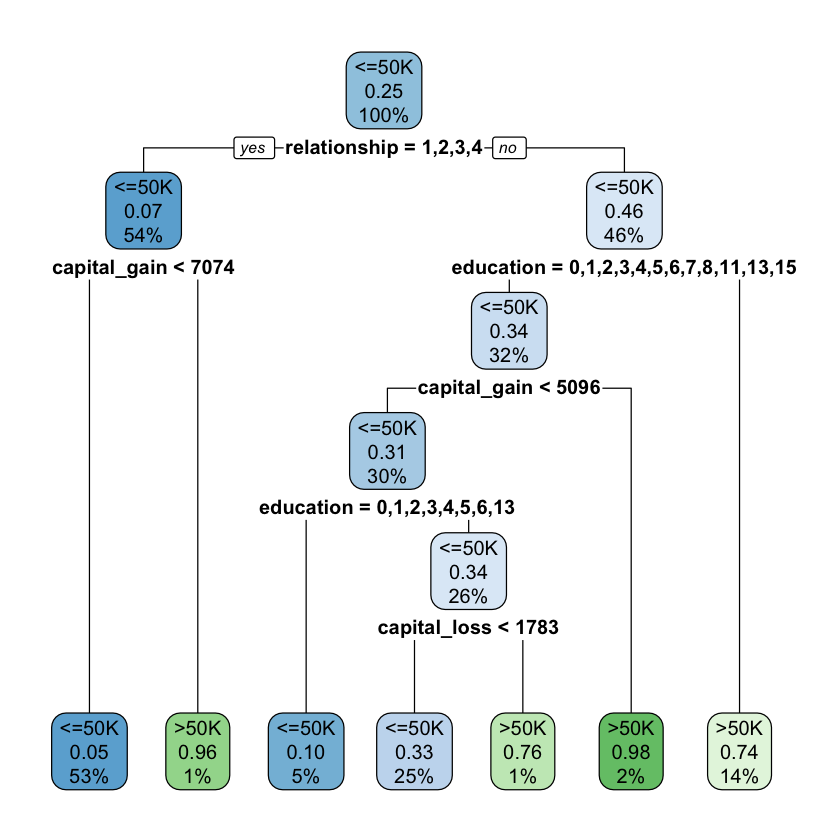

In [161]:
adult_tree_orig <- build_tree(adult)

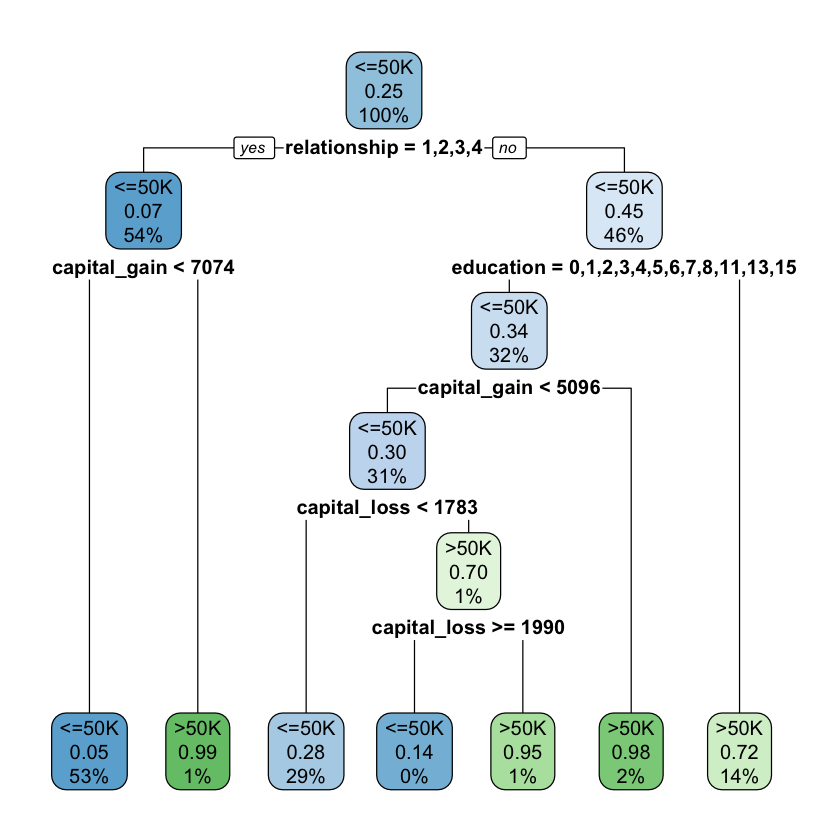

In [162]:
adult_tree_syn <- build_tree(syndata_cart_adult$syn)

#### Perfomance evaluation

In [163]:
cm_adult_orig <- confusionMatrix(adult_tree_orig$predictions$classes, adult_tree_orig$test_set$income, 
                mode = "everything")

In [164]:
cm_adult_syn <- confusionMatrix(adult_tree_syn$predictions$classes, adult_tree_syn$test_set$income,
                mode = "everything")

In [165]:
cm_adult_orig

Confusion Matrix and Statistics

          Reference
Prediction <=50K >50K
     <=50K  4310  700
     >50K    234  789
                                          
               Accuracy : 0.8452          
                 95% CI : (0.8358, 0.8542)
    No Information Rate : 0.7532          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5346          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9485          
            Specificity : 0.5299          
         Pos Pred Value : 0.8603          
         Neg Pred Value : 0.7713          
              Precision : 0.8603          
                 Recall : 0.9485          
                     F1 : 0.9022          
             Prevalence : 0.7532          
         Detection Rate : 0.7144          
   Detection Prevalence : 0.8304          
      Balanced Accura

In [166]:
cm_adult_syn

Confusion Matrix and Statistics

          Reference
Prediction <=50K >50K
     <=50K  4337  641
     >50K    227  828
                                         
               Accuracy : 0.8561         
                 95% CI : (0.847, 0.8649)
    No Information Rate : 0.7565         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.5682         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9503         
            Specificity : 0.5636         
         Pos Pred Value : 0.8712         
         Neg Pred Value : 0.7848         
              Precision : 0.8712         
                 Recall : 0.9503         
                     F1 : 0.9090         
             Prevalence : 0.7565         
         Detection Rate : 0.7189         
   Detection Prevalence : 0.8251         
      Balanced Accuracy : 0.7570         

In [167]:
(eval_adult <- evaluation_metrics_factor(adult_tree_orig$predictions$classes, adult_tree_orig$test_set, adult_tree_syn$predictions$classes, adult_tree_syn$test_set))

,Metric,Original,Synthetic,Difference
,<chr>,<dbl>,<dbl>,<dbl>
Accuracy,Accuracy,0.8451848,0.8561246,0.010939831
F1,F1,0.9022399,0.9090337,0.006793846
Sensitivity,Sensitivity,0.9485035,0.9502629,0.001759406
Specificity,Specificity,0.5298858,0.5636487,0.033762911
